# Data Set Information:

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# 1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
df.shape

(48204, 9)

In [5]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


**Удалим неинтересующие нас столбцы**

In [6]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [7]:
df = df.drop(columns=['rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description'], axis=1)
df.head(2)

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516


In [8]:
# targets = ['traffic_volume']
# features = [feature for feature in df.columns if feature not in targets]
# df.head()

In [9]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [10]:
df['temp'].unique()

array([288.28, 289.36, 289.58, ..., 306.08, 304.41, 304.9 ])

**Конверитируем колонку date_time в datetime и устанавливаем уё как индекс**

In [11]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df = df.set_index(pd.DatetimeIndex(df['date_time']))

**Проверим дубликаты**

In [13]:
df.duplicated().sum()

7551

In [14]:
df = df.drop_duplicates()

In [15]:
df.duplicated().sum()

0

In [16]:
df.shape

(40653, 4)

**Взглянем на пропущенные значения**

In [17]:
df.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

In [18]:
# ?pd.date_range

In [19]:
pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')

In [20]:
df = df.interpolate(method='ffill')
df

,holiday,temp,date_time,traffic_volume
date_time,,,,
2012-10-02 09:00:00,None,288.28,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,2012-10-02 13:00:00,4918
...,...,...,...,...
2018-09-30 19:00:00,None,283.45,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,None,282.76,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,None,282.73,2018-09-30 21:00:00,2159


**Попробуем взять только данные с июня 2018 по 30 сентября 2018**

In [21]:
df = df['2018-06-01':'2018-09-30']
df.head()

,holiday,temp,date_time,traffic_volume
date_time,,,,
2018-06-01 00:00:00,None,294.28,2018-06-01 00:00:00,786
2018-06-01 01:00:00,None,293.22,2018-06-01 01:00:00,497
2018-06-01 02:00:00,None,292.22,2018-06-01 02:00:00,346
2018-06-01 03:00:00,None,291.43,2018-06-01 03:00:00,395
2018-06-01 04:00:00,None,291.15,2018-06-01 04:00:00,872


In [22]:
df.shape

(2923, 4)

**Отложим последние две недели из датасета для тестов**

In [23]:
split_date = '2018-09-16'
df_train = df.iloc[df.index < split_date].copy()
df_test = df.iloc[df.index > split_date].copy()

In [24]:
(df_train.shape, df_test.shape)

((2563, 4), (359, 4))

In [25]:
def plot_data(df):
  """ Отрисока временного ряда """
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

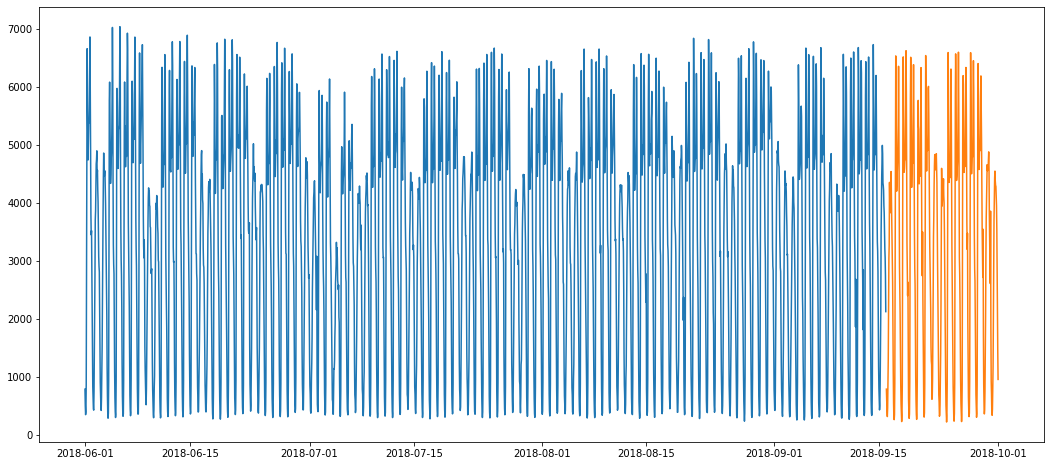

In [26]:
plot_data(df)

# Генерируем дополнительные признаки

In [27]:
def create_features(df, label=None):
    """
    Генерируем дополнительные признаки из datetime
    """
    df['date'] = df.index
    df['hour'] = df['date_time'].dt.hour
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['quarter'] = df['date_time'].dt.quarter
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year
    df['day_of_year'] = df['date_time'].dt.dayofyear
    df['day_of_month'] = df['date_time'].dt.day
    df['week_of_year'] = df['date_time'].dt.weekofyear
    
    X = df[['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [28]:
# df.groupby(['day_of_week', 'hour'])['traffic_volume'].mean()

**Деление на train и test**

In [29]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2563, 8), (359, 8), (2563,), (359,))

**Метрики**

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
  """ MAPE """
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
def error_metrics(y_true, y_pred):
  """ Подсчёт метрик и вывод на экран """
  print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
  print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
  print('Mean Absolute Percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

# LinearRegression

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
%%time
y_pred = lr.predict(X_test)

CPU times: user 3.28 ms, sys: 45 µs, total: 3.33 ms
Wall time: 3.23 ms


In [35]:
def plot_predictions(y_pred):
  """ Отрисока предсказаний """
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

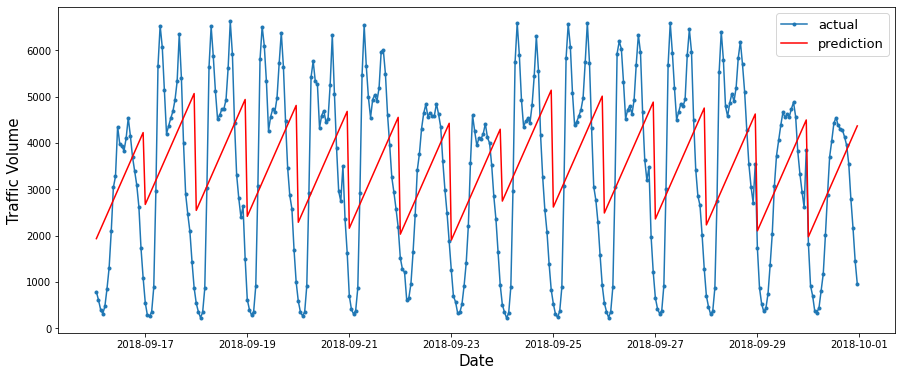

In [36]:
plot_predictions(y_pred)

In [37]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1568.33
Root Mean Squared Error: 1802.91
Mean Absolute Percentage Error: 141.51 %


In [38]:
def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

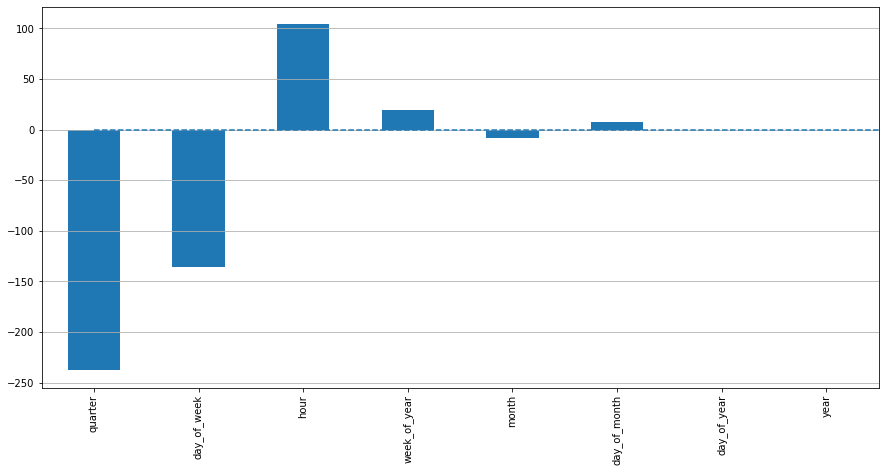

In [39]:
plotCoefficients(lr, X_train)

# GradientBoostingRegressor

In [40]:
%time
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


GradientBoostingRegressor()

In [41]:
%%time
y_pred = gb.predict(X_test)

CPU times: user 3.41 ms, sys: 47 µs, total: 3.46 ms
Wall time: 3.47 ms


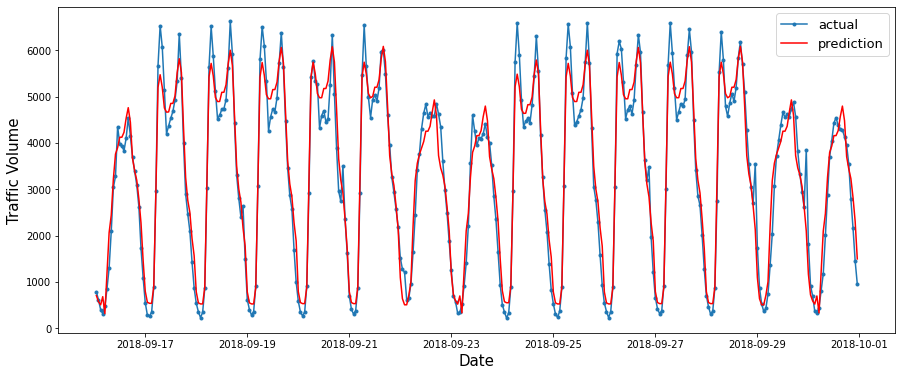

In [42]:
plot_predictions(y_pred)

In [43]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 316.66
Root Mean Squared Error: 401.45
Mean Absolute Percentage Error: 18.97 %


# XGBRegressor

In [44]:
%%time
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train)

CPU times: user 2.26 s, sys: 32.4 ms, total: 2.3 s
Wall time: 2.79 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
%%time
y_pred = reg.predict(X_test)

CPU times: user 6.64 ms, sys: 0 ns, total: 6.64 ms
Wall time: 6.7 ms


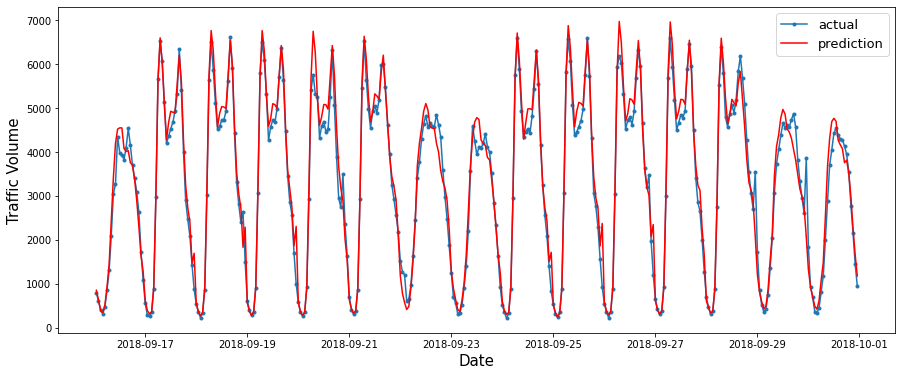

In [46]:
plot_predictions(y_pred)

In [47]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 236.67
Root Mean Squared Error: 343.56
Mean Absolute Percentage Error: 10.03 %


# RandomForestClassifier

In [48]:
%%time
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

CPU times: user 512 ms, sys: 16.9 ms, total: 528 ms
Wall time: 623 ms


RandomForestClassifier(max_depth=3, random_state=42)

In [49]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 358 ms, sys: 15.6 ms, total: 374 ms
Wall time: 542 ms


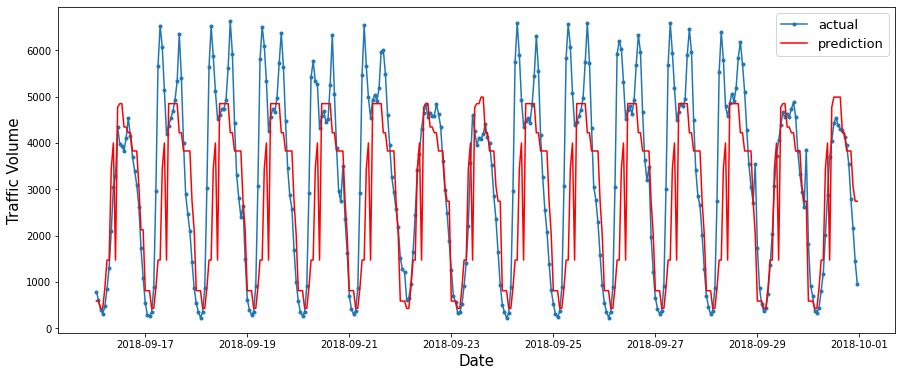

In [50]:
plot_predictions(y_pred)

In [51]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1005.28
Root Mean Squared Error: 1526.81
Mean Absolute Percentage Error: 40.44 %


# Prophet

In [52]:
# !pip install prophet

In [53]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df.index)
df_fbp["y"] = df['traffic_volume'].values

In [54]:
df_fbp.head()

,ds,y
0,2018-06-01 00:00:00,786
1,2018-06-01 01:00:00,497
2,2018-06-01 02:00:00,346
3,2018-06-01 03:00:00,395
4,2018-06-01 04:00:00,872


In [55]:
fb_y_train = df_fbp.iloc[:-359].copy()
fb_y_test = df_fbp.iloc[-359:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [56]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_7ewiq5/fir3it70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_7ewiq5/micempnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68292', 'data', 'file=/tmp/tmpv_7ewiq5/fir3it70.json', 'init=/tmp/tmpv_7ewiq5/micempnx.json', 'output', 'file=/tmp/tmpv_7ewiq5/prophet_modelcdl1w6kg/prophet_model-20230325125412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
354,2018-09-30 19:00:00,3380.104747,2321.713809,4323.241432,3367.488158,3391.218489,-35.181457,-35.181457,-35.181457,374.778220,374.778220,374.778220,-409.959678,-409.959678,-409.959678,0.0,0.0,0.0,3344.923290
355,2018-09-30 20:00:00,3380.104850,1729.565087,3733.126005,3367.442877,3391.252725,-702.024119,-702.024119,-702.024119,-329.424970,-329.424970,-329.424970,-372.599148,-372.599148,-372.599148,0.0,0.0,0.0,2678.080732
356,2018-09-30 21:00:00,3380.104954,1211.606151,3191.369840,3367.399179,3391.283327,-1158.117216,-1158.117216,-1158.117216,-822.902901,-822.902901,-822.902901,-335.214315,-335.214315,-335.214315,0.0,0.0,0.0,2221.987738
357,2018-09-30 22:00:00,3380.105057,973.683168,2881.667651,3367.344212,3391.313928,-1463.346866,-1463.346866,-1463.346866,-1165.323592,-1165.323592,-1165.323592,-298.023274,-298.023274,-298.023274,0.0,0.0,0.0,1916.758191
358,2018-09-30 23:00:00,3380.105160,512.967912,2611.984532,3367.261454,3391.345136,-1826.604029,-1826.604029,-1826.604029,-1565.368768,-1565.368768,-1565.368768,-261.235262,-261.235262,-261.235262,0.0,0.0,0.0,1553.501131


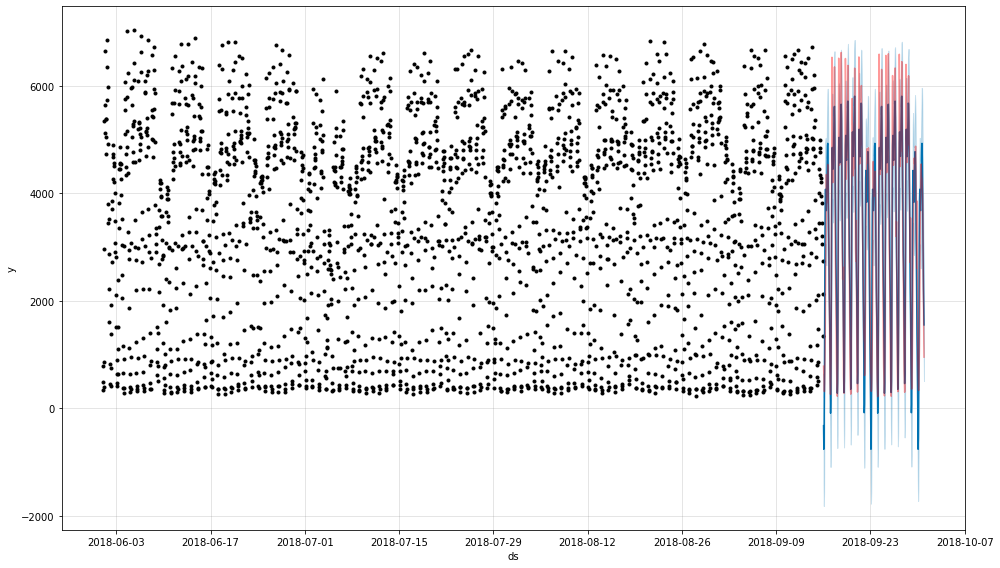

In [58]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [59]:
plot_plotly(fbmodel, forecast)

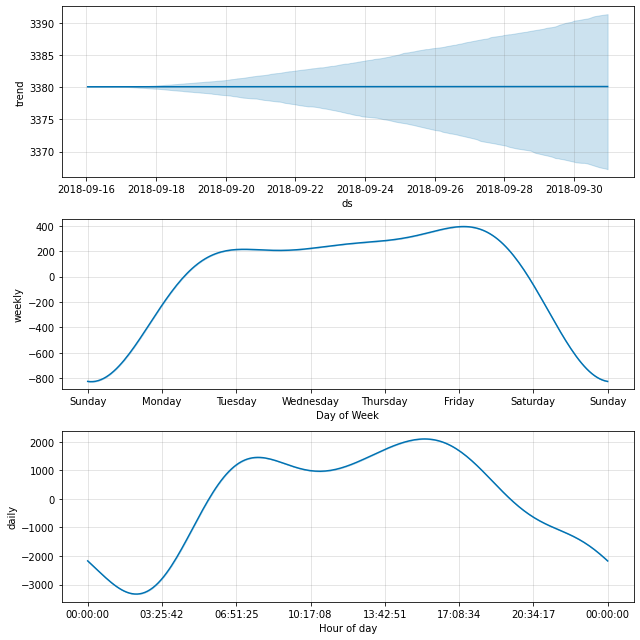

In [60]:
_ = fbmodel.plot_components(forecast)

# ARIMA

In [61]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

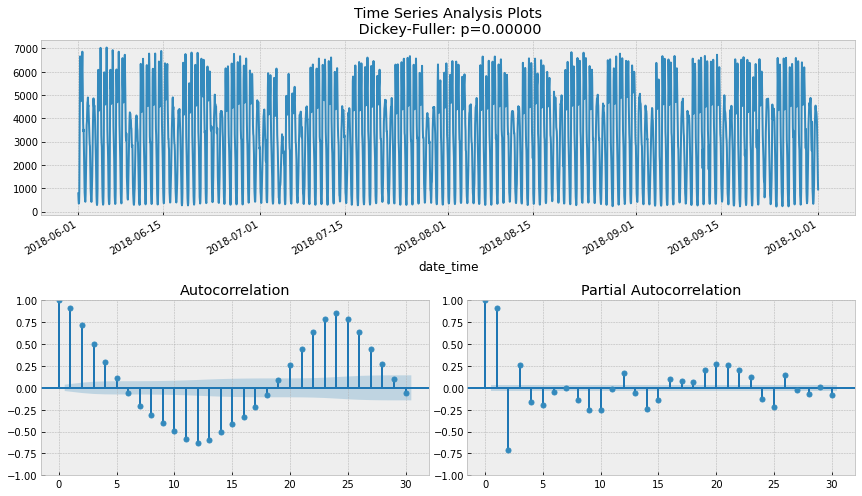

In [62]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

tsplot(df['traffic_volume'], lags=30)

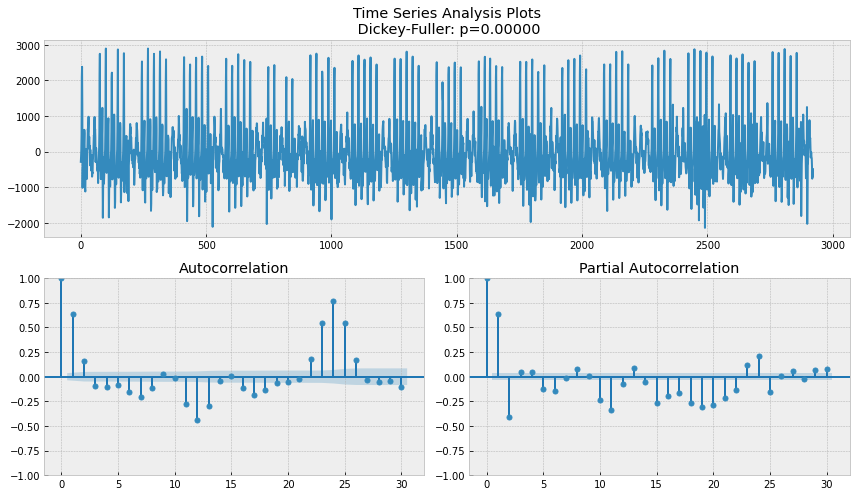

In [63]:
# Конечная разность (первого порядка, численное дифференцирование)
_diff_1 = df['traffic_volume'].values[1:] - df['traffic_volume'].values[:-1]
tsplot(_diff_1, lags=30)

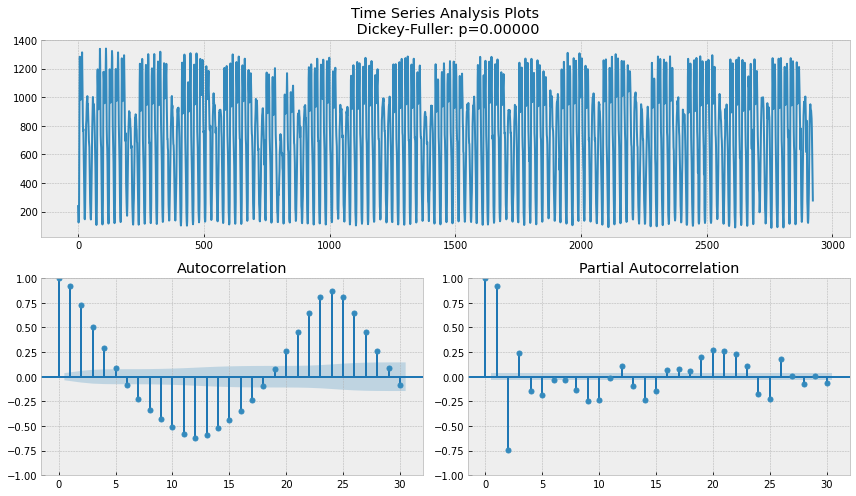

In [64]:
from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox


# Преобразование к стационарному виду (преобразование Бокса-Кокса)
# автокорреляционная функция показывает сезонность
transfromed_series_a, bc_lamb = boxcox(df['traffic_volume'])

tsplot(transfromed_series_a, lags=30)

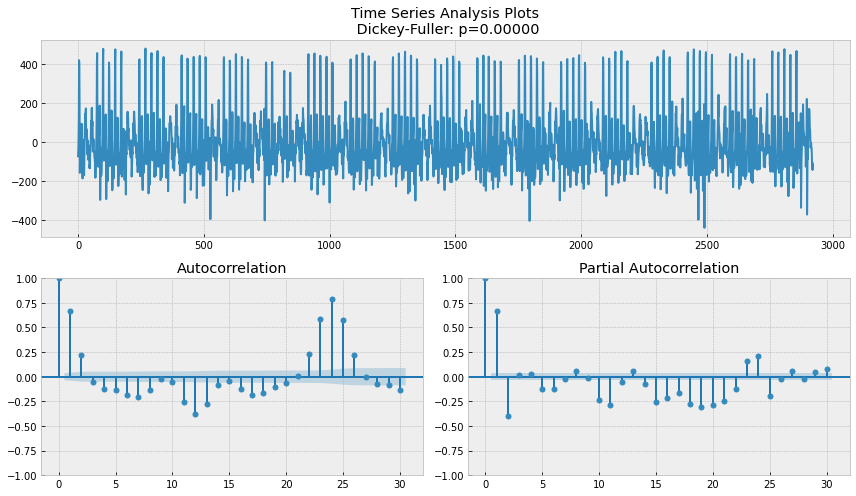

In [65]:
# Разность первого порядка (критерий Дики-Фуллера отвергает гипотезу, но в пограничных значениях)
# При этом автокорреляционная функция показывает сезонность
tsplot(transfromed_series_a[1:] - transfromed_series_a[:-1], lags=30)

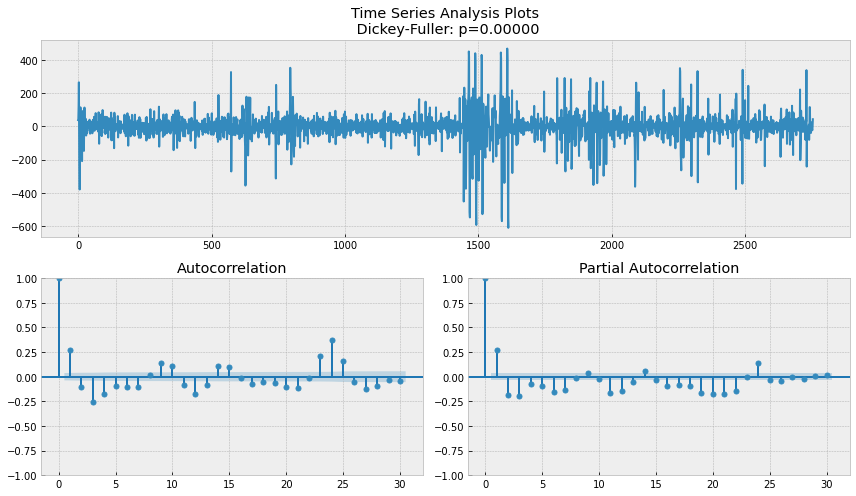

In [66]:
# + Сезонная разность
diff = transfromed_series_a[1:] - transfromed_series_a[:-1]

seasons = 24 * 7

tsplot(diff[seasons:] - diff[:-seasons], lags=30)

In [67]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)

In [68]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    :param parameters_list:  list with (p, q, P, Q) tuples
    :type parameters_list:    list
    :param d:                integration order in ARIMA model
    :type d:                  int
    :param D:                seasonal integration order
    :type D:                  int
    :param s:                length of season
    :type s:                  int
    """
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [69]:
# Для решения проблемы:
# "Maximum Likelihood optimization failed to converge. Check mle_retvals"

# import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)

In [70]:
# Для решения проблемы:
# "A date index has been provided, but it has no associated
# frequency information and so will be ignored when e.g. forecasting."

# df.index = pd.DatetimeIndex(df.index).to_period('M')

In [71]:
# %%time

# ps = range(2, 4)
# d = 1
# qs = range(2, 4)
# Ps = range(0, 3)
# D = 1
# Qs = range(0, 3)
# s = 24 * 7

# # creating list with all the possible combinations of parameters
# parameters_list = list(product(ps, qs, Ps, Qs))

# result_table = optimizeSARIMA(df['traffic_volume'], parameters_list, d, D, s)

In [72]:
# result_table.head()

In [73]:
# p, q, P, Q = result_table.parameters[0]
# best_model = sm.tsa.statespace.SARIMAX(df['traffic_volume'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
# print(best_model.summary())

In [74]:
# plotSARIMA(df, best_model, n_steps=50, s=s, d=d, plot_intervals=True, alpha=0.5)